<a href="https://colab.research.google.com/github/Vitorjipa22/ICP/blob/main/ICP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

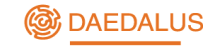
# Questão 01 do processo seletivo da Daedalus 

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Imports

In [ ]:
import trimesh
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.neighbors import NearestNeighbors

## Carregando a point cloud

In [ ]:
point_clouds = list()

for i in range(30):
  if i < 10:
    point_clouds.append(trimesh.load("00000" + str(i) +"_points.obj").vertices)
  else:
    point_clouds.append(trimesh.load("0000" + str(i) +"_points.obj").vertices)


In [ ]:
point_cloud_source = point_clouds[0]
point_cloud_source = np.array(point_cloud_source)
point_cloud_source = point_cloud_source[:62340][:]

In [ ]:
point_cloud = point_clouds[1]
point_cloud = np.array(point_cloud)

## Criando a matriz T por meio da algebra encontrada nos sites de referencias.

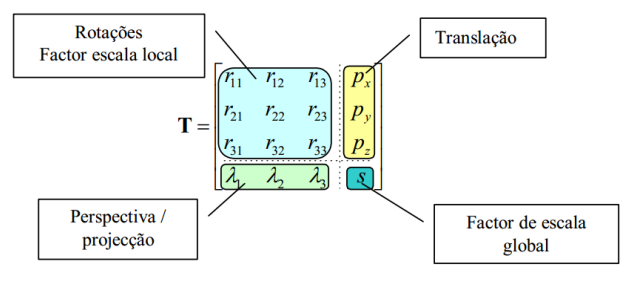

In [ ]:
def transformada(ptcs, ptc):
    '''
      Função para encontrar matriz de transformação
      T: Matriz de transformação (4x4) de ptcs para ptc. As dimensões são especificas deste caso
      R: Matriz de rotação (3x3)
      t: Matriz coluna (3x1) chamada de matriz de translação 
    '''
    
    #numero de dimensões dos pontos
    dim = 3 

    # Tratando a diferença de quantidade de pontos
    if ptcs.shape[0] > ptc.shape[0]:
      ptcs = ptcs[:ptc.shape[0],0]

    elif ptcs.shape[0] < ptc.shape[0]:
      ptc = ptc[:ptcs.shape[0],0]

    # Calculando centro de massa do ptcs
    P = np.mean(ptcs, axis=0)

    # Calculando centro de massa do ptc
    Q = np.mean(ptc, axis=0)

    # calculando a distancia dos pontos para o centro de massa
    P_linha = ptcs - P
    Q_linha = ptc - Q

    # Usando Singular Value Decomposition para encontrar R
    U, S, Vt = np.linalg.svd(np.dot(P_linha.T, Q_linha))

    # encontrando R
    R = np.dot(Vt.T, U.T)

    # encontrando t
    t = Q.T - np.dot(R,P.T)

    # criando T a partir de R e t
    T = np.identity(dim+1)
    T[:dim, :dim] = R
    T[:dim, dim] = t

    return T

## função de nearest neighbor para calcular a distancia dos estados.

In [ ]:
def nearest_neighbor(src, dst):

    if src.shape[0] > dst.shape[0]:
      src = src[:dst.shape[0],0]

    elif src.shape[0] < dst.shape[0]:
      dst = dst[:src.shape[0],0]

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    
    return distances.ravel(), indices.ravel()

## Função final que gera as iterações de um estado para o outro baseado nas outras duas funções.

In [ ]:
def icp(A, B, T_completo,T_final, max_iterations=20, tolerance=0.001):
  '''
  Função para computar as tranformadas de um estado para o outro
  '''

  if A.shape[0] > B.shape[0]:
    A = A[:B.shape[0],:]

  elif A.shape[0] < B.shape[0]:
    B = B[:A.shape[0],:]

  # numero de dimensões
  m = 3

  # aumentando a dimensão da matriz original para a multiplicação matricial dar certo
  src = np.ones((m+1,A.shape[0]))
  dst = np.ones((m+1,B.shape[0]))

  src[:m,:] = np.copy(A.T)
  dst[:m,:] = np.copy(B.T)

  prev_error = 0

  for i in range(max_iterations):
      # encontrando os vizinhos proximos pela nearest neighbor
      distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

      # encontrando a transformada desta iteração 
      T = transformada(src[:m,:].T, dst[:m,indices].T)
      T_completo.append(T)

      # atualizando o valor atual de estado
      src = np.dot(T, src)

      # atualizando o erro
      mean_error = np.mean(distances)

      # verificando se o erro é maior que a tolerancia
      if np.abs(prev_error - mean_error) < tolerance:
          break

      prev_error = mean_error

  # transformada final
  T = transformada(A, src[:m,:].T)
  
  T_final.append(T)
  T_completo.append(T)

  return T_completo, T_final

## Obtendo resultados e plotando os graficos.


In [ ]:
T_completo = list()
T_final = list()

for i in range(len(point_clouds)-1):
  TT, T_final = icp(point_clouds[i],point_clouds[i+1], T_completo, T_final)


In [ ]:
x_data = list()
y_data = list()
z_data = list()

point = np.array([1,1,1,1])

In [ ]:
x_data.append(point[0])
y_data.append(point[1])
z_data.append(point[2])

for i in range(len(T_final)):
  point = np.dot(T_final[i], point.T)

  x_data.append(point[0])
  y_data.append(point[1])
  z_data.append(point[2])

### Plot apenas com as transformadas finais de cada mudança de estado (29)

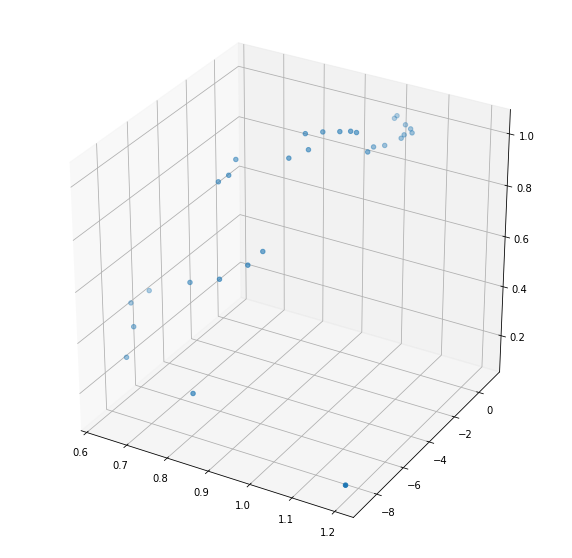

In [ ]:
point = np.array([1,1,1,1])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_data, y_data, z_data)
plt.show()

In [ ]:
x_data = list()
y_data = list()
z_data = list()

point = np.array([1,1,1,1])

In [ ]:
x_data.append(point[0])
y_data.append(point[1])
z_data.append(point[2])

for i in range(len(T_completo)):
  point = np.dot(T_completo[i], point.T)

  x_data.append(point[0])
  y_data.append(point[1])
  z_data.append(point[2])

### Plot com o resultado de cada iteração para cada mudança de estado (268)

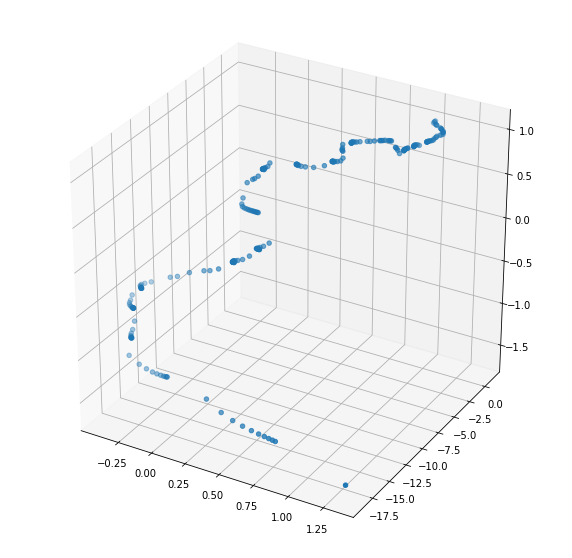

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_data, y_data, z_data)
plt.show()

## Referencias:
https://abcm.org.br/upload/files/PII_VI_05.pdf 
http://www.joinville.ifsc.edu.br/~michael.klug/ROB74/Aulas/aula2_trans_geometricas.pdf
https://trimsh.org/trimesh.registration.html

https://www.youtube.com/watch?v=mboTCvuycmo obs: desse link eu tirei os calculos

https://www.youtube.com/watch?v=CzbETzWgFrc